## TASK

To improve it you can
1. have a look on the current section 2 and specifications of the algorithms. Is it ok for you? I've tried to make both algorithms interfaces as close as possible (no \gamma but only k; no \DD_M matrix but \CC_M, etc)
2. change interfaces (outputs) of algorithms 1 and 2 according to the specs. Let a_star always be the output. M and matrix be the optional output. And for the discrete algorithm there will be an option either to provide matrix in current form (indexes for packages/assets per package) or in the same way as in continuous case (composition matrix \CC_M)
3. add unit tests to the notebook (https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook) to check
* algorithms
* some information about data (correct sizes, for example)
Use assertEqual for integers and assertTrue+numpy.allclose for real numbers



If we consider discrete tokenization as a separate problem then it is good to use a Boolean matrix to indicate the presence of the asset. But once we consider discrete tokenization along with the continuous one, it becomes reasonable to use the same objects for the same tasks. In our case,

» Do we need to change code according to algorithm in overleaf such as \vec A = k \cdot \vec A? Because we do A*k and a_star = a_star/k  outside the def in the previous code.  

The best way is to have an option with the default option to normalize inside function and an alternative not to normalize inside.

» Do I need to change name from a_star to a or my_matrix to C_M?

 A straightforward solution is to use the same notations in the paper and code, i.e. change a_star to a and my_matrix to C_M. But it is also ok to use a bit different notations. The only obligatory thing is not to use "my_matrix" as it is neither from paper nor clear.

In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import math
from datetime import date, timedelta
from numpy import sqrt,mean,log,diff
from matplotlib import pyplot as plt
import unittest
import seaborn as sns
import heapq
from sympy import symbols, solve, Eq
import json 
import unittest

In [2]:
# Open Forex data file
def open_file(qq):
    data_list = []
    name = str(qq) + '.csv'
    with open(name, 'r') as reading:
        file_input = reading.read().split('\n')

    for row in file_input:
        data_list.append(row.split('\t'))
    data = pd.DataFrame(data_list,columns=['date', 'open', 'high', 'low', 'close', 'vol'])
    data['close'] = pd.to_numeric(data['close'],errors = 'coerce')
    data['vol'] = pd.to_numeric(data['vol'],errors = 'coerce')
    return data

# Exchange rate and volume of Forex data 
def get_rate_and_volume(data_file_name, V, start_date, end_date):
    exchange_rate = list()
    volume = list()
    for i, single_date in enumerate(daterange(start_date, end_date)):
        a_date = single_date.isoformat()+str(' 00:00')
        if a_date not in open_file(data_file_name)['date'].values:
            a_date = (single_date-timedelta(days=1)).isoformat()+str(' 00:00')
        print(a_date)
        exchange_rate.append(float(open_file(data_file_name).loc[open_file(data_file_name)['date']== a_date]['close'].values))
        exchange_rate.append(V * float(open_file(data_file_name).loc[open_file(data_file_name)['date']== a_date]['vol']))
    return exchange_rate, volume

In [3]:
start_date = date(2020, 1, 1)
end_date = date(2020, 12, 31)
pairs = ['EURUSD', 'AUDUSD', 'GBPUSD', 'NZDUSD']
V = 100

In [4]:
exchange_rates_array = list()
volumes_array = list()
dates_array = list()
foreign_risk_free_rate = list()
domestic_risk_free_rate = list()

# total Forex volume and exchange rate 
for pair_index in range(len(pairs)):
#     data_file_name = 'data/' + pairs[pair_index] + '1440'
    data_file_name = pairs[pair_index] + '1440'
    data = open_file(data_file_name)
    dates = data['date'].values
    dates = [x[:-6] for x in dates]
    exchange_rates = data['close'].values
    volumes = data['vol'].values
    start_index = [i for i in range(len(dates)) if dates[i] == str(start_date)][0]
    end_index = [i for i in range(len(dates)) if dates[i] == str(end_date)][0]
    dates_array.append(dates[start_index:end_index+1])
    exchange_rates_array.append(exchange_rates[start_index:end_index+1])
    volumes_array.append(volumes[start_index:end_index+1])

exchange_rates_array = np.array(exchange_rates_array)
volumes_array = np.array(volumes_array)

In [5]:
print(np.shape(exchange_rates_array))
print(np.cov(exchange_rates_array))
print(np.corrcoef(exchange_rates_array))

(4, 314)
[[0.00198052 0.0016558  0.00133738 0.0012721 ]
 [0.0016558  0.00169787 0.00137727 0.00130886]
 [0.00133738 0.00137727 0.00163975 0.00118338]
 [0.0012721  0.00130886 0.00118338 0.00109828]]
[[1.         0.90295525 0.74212144 0.86252955]
 [0.90295525 1.         0.8254235  0.95848165]
 [0.74212144 0.8254235  1.         0.88181901]
 [0.86252955 0.95848165 0.88181901 1.        ]]


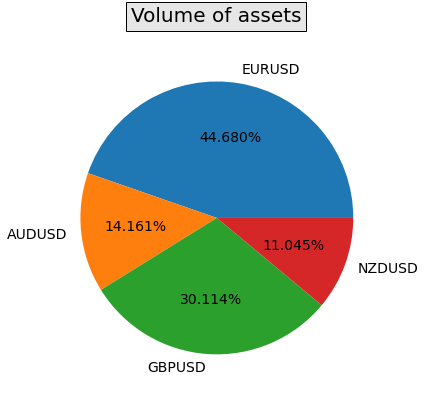

In [6]:
# Total trading volume 
fig = plt.figure(figsize=(6,6))
plt.pie(np.sum(volumes_array, axis=1), labels=pairs,autopct='%1.3f%%', radius = 2, textprops={'fontsize': 14})
plt.title("Volume of assets", bbox={'facecolor':'0.9', 'pad':5}, fontsize = 20)
plt.axis('equal')
plt.tight_layout()
plt.show()

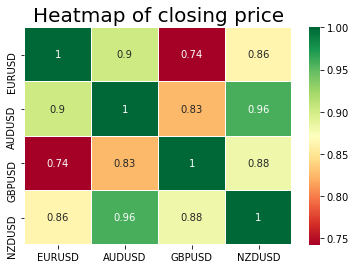

In [7]:
# Correlation between different currency pair
exchange_rates_pd = pd.DataFrame(exchange_rates_array.transpose(), columns = pairs)

ax = sns.heatmap(exchange_rates_pd.corr(), cmap='RdYlGn', linewidths=.1,annot=True)
plt.title("Heatmap of closing price", fontsize = 20)
plt.show()

The assumption of dataset is that each currency pair isn't correlating with each other while there is almost one correlation factor except diagonal. To sum up, this correlation matrix shows that we have the wrong model assumptions.

## Discrete tokenization

In [8]:
class Discrete:
    def __init__(self, A0, N0, k0):
        self.A = A0.astype(int) # array of assets
        self.N = N0 # number of assets types
        self.k = k0 # number of assets in each package


    def preprocess(self):
        assert self.N == len(self.A), "Wrong N"  
        assert self.k <= len(self.A), "Wrong k" 
        self.A = self.A * self.k
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes] 
        a = np.sort(self.A, axis=None) # min-max sorting
        largest_ele_index = heapq.nlargest(self.k-1, range(len(a)))
        S = 0
        for i in range(0, len(a)):
            if i not in largest_ele_index:
                S = S + np.sum(a[i]) # sum of all token except biggest k-1 types
        B = 0
        n = 2
        a_res = a
        for start in range(self.N - self.k+1,self.N): # a_{N-k+n} = min[A_{N-k+n}, S/(n-1)] to remove some tokens
            index_S_inner = self.N-self.k+n-1
            S_inner = np.sum(a[0:index_S_inner])
            if math.floor(S_inner/(n-1)) >= A[self.N-self.k+n-1]:
                a_res[self.N-self.k+n-1] = A[self.N-self.k+n-1]
                S = S + a_res[index_S_inner]
            else:
                a_res[self.N-self.k+n-1] = math.floor(S_inner/(n-1))
                S = S + a_res[index_S_inner]
            assert a_res[self.N-self.k+n-1] == min(A[self.N-self.k+n-1],math.floor(S_inner/(n-1)))
            delta = A[index_S_inner] - a_res[index_S_inner] 
            B = B + delta # total number of tokens put off from packages
            n = n+1            
        return a_res, B


    def distribution(self, a_res, B, return_distribution_matrix=False):
        S = np.sum(a_res)
        M = math.floor(S/self.k)
        B0 = abs(S - M*self.k) # number of token that isn't falling into packages due to multiplicity of S
        n = self.N - B0 +1
        for n in range(n, self.N+1):
            a_res[n-1] = a_res[n-1] - 1 # remove 1 tokens from last token's types
            B = B + B0
        l_n = np.zeros(self.N+1)
        r_n = np.zeros(self.N+1)
        for n in range(1,self.N+1):
            l_n[n] = np.sum(a_res[0:n-1])+1
            r_n[n] = np.sum(a_res[0:n])
        if return_distribution_matrix: # unique composition of each package as much as possible 
            C_M = np.zeros((self.k, M))
            n = 1
            for i in range(1, M + 1):
                for j in range(1, self.k+1):
                    check_index = i + M * (j - 1)
                    for n in range(1, self.N+1):
                        if check_index <= r_n[n] and check_index >= l_n[n]:
                            C_M[j-1, i-1] = self.inverse_sort_indexes[n-1] + 1
                        n =n+1
            return a_res[self.inverse_sort_indexes]/self.k, M, C_M
        else:
            return a_res[self.inverse_sort_indexes]/self.k, M

In [9]:
class Discrete_Test(unittest.TestCase):
    def setUp(self):
        self.A_t = np.array([3, 4, 3, 5, 7, 2])
        self.k_t = 4
        self.res = Discrete(self.A_t, len(self.A_t), self.k_t)
    
    def test_preprocess(self):
        a_preprocess, B =  self.res.preprocess()
        np.array_equal(a_preprocess, [8, 12, 12, 16, 20, 22])
        self.assertEqual(B, 6)
    
    def test_distribution(self):
        a_preprocess, B = self.res.preprocess()
        a_dis, M, C_M = self.res.distribution(a_preprocess, B, return_distribution_matrix=True)
        self.assertTrue(np.allclose(a_dis, [3, 4, 3, 4.75, 5.25, 2]))
        self.assertEqual(M, 22)
        actual_C_M = [[2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,],
                     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,],
                     [5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,],
                     [6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,]]
        np.array_equal(C_M, actual_C_M)

unittest.main(argv=[''], verbosity=2, exit=False)

test_distribution (__main__.Discrete_Test) ... ok
test_preprocess (__main__.Discrete_Test) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


In [10]:
# test example

A = np.array([3, 4, 3, 5, 7, 2])
N = len(A)
k = 4
res_discrete = Discrete(A, N, k)
res_1, B = res_discrete.preprocess()
a_res, M, my_matrix = res_discrete.distribution(res_1, B, return_distribution_matrix=True)
print('A:', A)
print('a:', a_res)
print(f'C_M: \n', my_matrix)

A: [3 4 3 5 7 2]
a: [3.   4.   3.   4.75 5.25 2.  ]
C_M: 
 [[2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [11]:
# Test volume of Forex data as input

np.floor(volumes_array[:, 0])
k = 3
A = np.floor(volumes_array[:, 0]).astype(int)
N = len(A)
res_discrete = Discrete(A, N, k)
res_1, B = res_discrete.preprocess()
a_res, _ = res_discrete.distribution(res_1, B)
print("A: ", volumes_array[:, 0])
print("a: ", a_res.astype(float))

A:  [ 2631  3364 13079  3966]
a:  [2631. 3364. 4980. 3966.]


In [12]:
# Tokenized volume by using discrete tokenization algorithm

k = 3
N = len(pairs)

tokenized_volume = np.zeros((volumes_array.shape[1],))
for trading_day_index in range(len(volumes_array[0])):
    A = np.floor(volumes_array[:, trading_day_index]).astype(int) 
    res_discrete = Discrete(A, N, k)
    res_1, B = res_discrete.preprocess()
    a_res, _ = res_discrete.distribution(res_1, B) 
    tokenized_volume[trading_day_index] = np.sum(a_res)

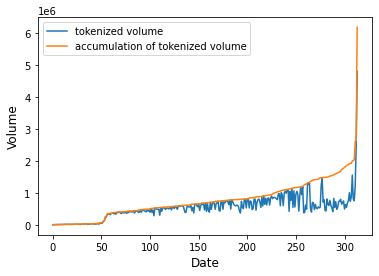

In [13]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))

plt.plot(tokenized_volume[sort_indexes],label = "tokenized volume")
plt.plot(np.sum(volumes_array, axis=0)[sort_indexes],label = "accumulation of tokenized volume")
# plt.title("Daily trading volume (discrete)", fontsize = 16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.legend()
plt.show()

Tokenized fraction:  0.7061052803816608


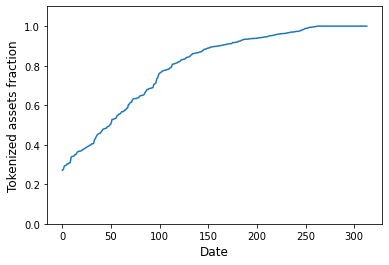

In [14]:
data_to_plot_discrete = [tokenized_volume[x] / np.sum(volumes_array[:, x]) for x in range(len(tokenized_volume))]

plt.plot(np.sort(data_to_plot_discrete))
# plt.title("Tokenized assets fraction (discrete)", fontsize = 16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.ylim([0,1.1])
print("Tokenized fraction: ", np.sum(tokenized_volume) / np.sum(volumes_array))

In [15]:
covariances = np.cov(exchange_rates_array)
allowed_package_covariance = np.zeros((len(pairs),))
for index in range(len(pairs)):
    vector = np.ones((len(pairs),)) / k
    vector[index] = 0
    current_covariance = np.matmul(np.matmul(vector, covariances), vector)
    allowed_package_covariance[index] = current_covariance
print("Max covariance: ", np.max(covariances))
print("Max package variance: ", np.max(allowed_package_covariance))
print("(Minium) Reduction factor vs k: ", (np.max(covariances) / np.max(allowed_package_covariance)), ' vs ', k)

Max covariance:  0.0019805239767943256
Max package variance:  0.0015621152653092344
(Minium) Reduction factor vs k:  1.2678475275012844  vs  3


The total number of tokenized tokens is a_star. The tokenized faction below than one means that some assets in A haven't been tokenized due to the multiplicity of a total number of S tokens in the size of packages k. Therfore, around 70.61% of dataset has been tokenized. In addition, the variance reduction factor is just 1.26 or 26% less, not equal to 3 times less due to the wrong model assumption

## Continuous tokenization

In [16]:
import numpy as np
from sympy import symbols, solve, Eq
class Continuous:
    def __init__(self, N0, A0, var_reduc):
        self.A = A0
        self.N = N0
        self.var = var_reduc 

    def search(self):
        N = self.N
        assert self.N == len(self.A), "Wrong N" 
        var = self.var
        E = np.array([0],dtype='float64') # expectation of taken assets
        V = np.array([0],dtype='float64') # varaince of taken assets
        a = np.zeros(self.N)
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes]
        A = np.insert(A, 0, 0)
        for n in range(0, N): # replace a_k from A_n with A_{n+1}
            E_new = E + (N-n)*(A[n+1] - A[n])
            V_new = V + (N-n)*(A[n+1]**2 - A[n]**2)
            if (1/var)*(E_new)**2 >= V_new:
                E = E_new
                V = V_new
                for k in range(n, N):
                    a[k] = A[n+1]
            else:
                x = symbols('x')
                eq = (1/var)*(E + (N - n)*(x - A[n]))**2 - V - (N - n) * (x**2 - A[n]**2)
                A_sol = solve(eq)
                assert A_sol != [{x: 0.0}], "Root equals to zero" 
                A_sol =  min(list(A_sol[1].values())[0], A[n + 1])
                E = E + (N-n)*(A_sol - A[n])
                V = V + (N-n)*(A_sol**2 - A[n]**2)
                n_star = n + 1
                for k in range(n_star-1, N):
                    a[k] = A_sol
        return a[self.inverse_sort_indexes]

    def construct_pack(self, a):
        M = np.linalg.norm((a), ord=1) # number of packages
        C_M  = a/M # composition of each M packages
        return  a[self.inverse_sort_indexes], M, C_M

In [17]:
class Continuous_Test(unittest.TestCase):
    def setUp(self):
        self.A_t = np.array([50, 8, 100, 3])
        self.res =  Continuous(len(self.A_t), self.A_t, 3)
    
    def test_search(self):
        a_search =  self.res.search()
        self.assertTrue(np.allclose(a_search, [19.48528137, 8, 50, 3]))
    
    def test_construct_pack(self):
        a_search = self.res.search()
        a_cons, M, C_M = self.res.construct_pack(a_search)
        self.assertTrue(np.allclose(a_cons,[50, 8, 3, 19.48528137]))
        self.assertTrue(np.allclose(C_M, [0.24209745, 0.09939706, 0.6212316, 0.0372739 ]))
        self.assertAlmostEqual(M, 80.48528137423853)

unittest.main(argv=[''], verbosity=2, exit=False)

test_construct_pack (__main__.Continuous_Test) ... ok
test_search (__main__.Continuous_Test) ... ok
test_distribution (__main__.Discrete_Test) ... ok
test_preprocess (__main__.Discrete_Test) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.286s

OK


In [18]:
# test example
A = np.array([3,2,7,4,9]) 
N = len(A)

my_var = np.var(A)
length = len(A)
my_min = np.min(A)
my_max = np.max(A)
rand1 = np.random.randint(my_min, my_max + 1, size=length)
rand2 = np.random.randint(my_min, my_max + 1, size=length)
cov_rand = np.cov(rand1, rand2)[0, 0]
var_red = cov_rand/my_var

res_conti = Continuous(N, A, var_red)
res_1 = res_conti.search()
print("final a_n = ", res_1)
a, _, C_M = res_conti.construct_pack(res_1)
print("composition is", C_M)

final a_n =  [3. 2. 7. 4. 9.]
composition is [0.12 0.08 0.28 0.16 0.36]


In [19]:
# test example

k = 3

A = np.array([1000, 1, 1, 1])
res_conti = Continuous(len(A), A, k)
print
res_1 = res_conti.search()
a, _, C_M = res_conti.construct_pack(res_1)
print("final a_n = ", res_1)
print("composition is", C_M)

final a_n =  [3. 1. 1. 1.]
composition is [0.5        0.16666667 0.16666667 0.16666667]


In [20]:
# Tokenized volume by using continuous tokenization algorithm

k = 3
N = len(pairs)

tokenized_volume = np.zeros((volumes_array.shape[1],))
package_variance = np.zeros((volumes_array.shape[1],))
for trading_day_index in range(len(volumes_array[0])):
    A = volumes_array[:, trading_day_index]
    res_conti = Continuous(N, A, k)
    res_1 = res_conti.search()
    a, _, C_M = res_conti.construct_pack(res_1)
    tokenized_volume[trading_day_index] = np.sum(res_1)
    package_variance[trading_day_index] = np.matmul(np.matmul(C_M, covariances), C_M)


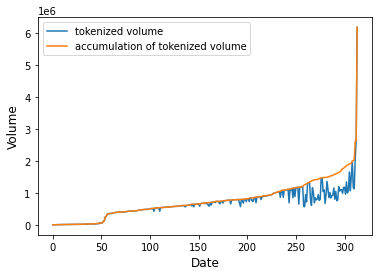

In [21]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))

plt.plot(tokenized_volume[sort_indexes],label = "tokenized volume")
plt.plot(np.sum(volumes_array, axis=0)[sort_indexes],label = "accumulation of tokenized volume")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
# plt.title("Daily trading volume (continuous)", fontsize = 16)
plt.legend()
plt.show()

Tokenized fraction:  0.8623487679062549


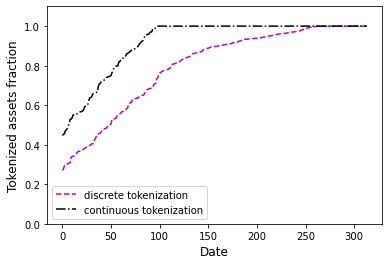

In [22]:
data_to_plot_continuous = [tokenized_volume[x] / np.sum(volumes_array[:, x]) for x in range(len(tokenized_volume))]

plt.plot(np.sort(data_to_plot_discrete), '--m',label = "discrete tokenization")
plt.plot(np.sort(data_to_plot_continuous), '-.k',label = "continuous tokenization")
plt.ylim([0,1.1])
# plt.title("Tokenized assets fraction (discrete)", fontsize = 16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.legend()
print("Tokenized fraction: ", np.sum(tokenized_volume) / np.sum(volumes_array))

In [23]:
covariances = np.cov(exchange_rates_array)
print("Max covariance: ", np.max(covariances))
print("Max package variance: ", np.max(package_variance))
print("(Minium) Reduction factor vs k: ", (np.max(covariances) / np.max(package_variance)), ' vs ', k)

Max covariance:  0.0019805239767943256
Max package variance:  0.001617381498381101
(Minium) Reduction factor vs k:  1.2245249366192874  vs  3


The tokenized fraction of continuous tokenization is around 86.23% which is higher than discrete tokenization. Continuous tokenization is suitable for a large class of dataset because this tokenization could consider a wider class of tokenized matrix for tokenization, instead of an integer. In contrast, discrete tokenization is suitable for the smaller dataset. Moreover, the varaince reduction is not equal to 3 due to wrong model assumption.

## Information for blockchain

In [24]:
trading_day_index = 0
dict_for_blockchain = dict()
dict_for_blockchain['trading_day'] = dates_array[0][trading_day_index]

k = 3
A = volumes_array[:, trading_day_index]
res_conti = Continuous(len(A), A, k)
res_1 = res_conti.search()
a, _, C_M = res_conti.construct_pack(res_1)
dict_for_blockchain['packages_number'] = round(sum(res_1))
dict_for_blockchain['package_content'] = list(C_M)
dict_for_blockchain['pairs'] = pairs

json_for_blockchain = json.dumps(dict_for_blockchain, indent = 4)  
print(json_for_blockchain)

{
    "trading_day": "2020-01-01",
    "packages_number": 19786,
    "package_content": [
        0.13297611027629772,
        0.1700234264422142,
        0.4965507280645376,
        0.2004497352169505
    ],
    "pairs": [
        "EURUSD",
        "AUDUSD",
        "GBPUSD",
        "NZDUSD"
    ]
}
